Importamos las librerías necesarias

In [52]:
import numpy as np
from scipy.integrate import odeint
import sir_mcmc_utils as utils
import pandas
import matplotlib.pyplot as plt

Leemos los datos del archivo 'data.dat' empleando pandas

In [53]:
# lectura de datos
df = pandas.read_csv('data.dat') #Lee los datos del archivo
print(df)

days = df['dia'].values
infected = df['Infectados']

    dia  Infectados
0     0           1
1    11           6
2    21          32
3    32         207
4    42        1068
5    53        6391
6    63       36125
7    74      179693
8    84      538146
9    95      555013
10  105      241360
11  116       74364
12  126       20874
13  137        5723
14  147        1533
15  158         391
16  168         122
17  179          35
18  189          11
19  200           2


Asignamos parámetros de la simulación Monte Carlo

In [117]:
#sigma_gamma = 0.0001;
#sigma_beta = 0.0001
#gamma = 0.333
#beta = 0.499
sigma_gamma = 0.01;
sigma_beta = 0.01
gamma = 0.5
beta = 0.5

like=0.0000000001
loglike=np.log(like)
Number_of_steeps = 10000
Burn_in_Time = 1000
mcmc_file_name = "mcmc.dat"

Corremos la simulación Monte Carlo


In [118]:
file_h = open(mcmc_file_name,"w+",buffering=1)
file_h.write('gamma,beta,log_likelihood\n')

for i in range(Number_of_steeps):
	#verificar que sea positivo
	gamma_try = np.random.normal(gamma, sigma_gamma)
	while (gamma_try < 0.0):
		gamma_try = np.random.normal(gamma, sigma_gamma)
	beta_try = np.random.normal(beta, sigma_beta)
	while (beta_try < 0.0):
		beta_try = np.random.normal(beta, sigma_beta)
		
	#definir el modelo con los parametros elegidos
	def model(y,t):
		return utils.SIR(y,t,gamma_try,beta_try)
		
	#resolver el modelo
	N0=10000000.0
	y0 = np.array([N0-1.,1.,0.])
	model_prediction = odeint(model, y0, days)
	
	#calcular likelihood
	loglike_try = utils.PoissonLikelihood(infected,model_prediction[:,1])
	
	#calcular numero aleatorio para comparar con la division de la anterior
	if (loglike_try < loglike):
		random = np.random.uniform(0.0,1.0)
		accepted = 0
	else:
		accepted = 1
		
	if (accepted == 1 or ( random < np.exp(loglike_try - loglike))):
		gamma = gamma_try
		beta = beta_try
		loglike = loglike_try

	if(i>Burn_in_Time):
		line = '{} , {} , {} \n'.format(gamma,beta,loglike)
		file_h.write(line)


file_h.close()

Leemos la Cadena Monte Carlo generada y elegimos los parámetros del modelo con mayor verosimilitud

In [119]:
MCMC = pandas.read_csv(mcmc_file_name)
MCMC.head()

,gamma,beta,log_likelihood
0,0.335986,0.5027,1.949550e+07
1,0.335986,0.5027,1.949550e+07
2,0.335986,0.5027,1.949550e+07
3,0.335986,0.5027,1.949550e+07
4,0.335986,0.5027,1.949550e+07


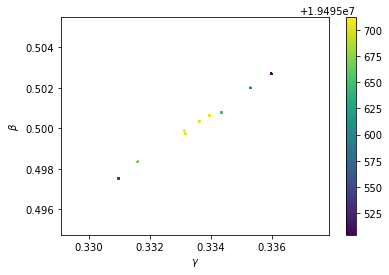

In [120]:


plt.scatter(x=MCMC.gamma,y=MCMC.beta,c=MCMC.log_likelihood,s=1)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
#plt.xlim([0.3328,0.3336])
#plt.ylim([0.4994,0.50025])
plt.show()


In [121]:
df = MCMC.drop_duplicates()
print(df.shape)
max_like = df['log_likelihood'].max()

best_parameters = df[df['log_likelihood']==max_like]
gamma_best = best_parameters['gamma'].values[0]
beta_best = best_parameters['beta'].values[0]
print(gamma_best)
print(beta_best)
MCMC.quantile([0.05,0.95])

(9, 3)
0.333137652329
0.499874819744


,gamma,beta,log_likelihood
0.05,0.331620,0.498356,1.949554e+07
0.95,0.334365,0.500787,1.949571e+07


Corremos el modelo con los parámetros encontrados y comparamos con los datos

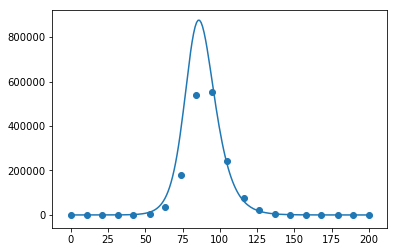

In [12]:
N0=10000000.0
y0 = np.array([N0-1.,1.,0.])
def model(y,t):
		return utils.SIR(y,t,gamma_best,beta_best)

time = np.linspace(0.0,200.0,200)
y = odeint(model,y0,time)
Model_Infected= y[:,1]
plt.plot(time,Model_Infected)

plt.scatter(days,infected)
plt.show()